# From Logistic Regression in SciKit-Learn to Deep Learning with TensorFlow – A fraud detection case study – Part II

We will continue to build our fraud detection model.  In the previous post we used scikit-learn to detect fraudulent transactions with a logistic regression. This time we will build a logistic regression in TensorFlow from scratch. We will start with some TensorFlow basics and then see how to implement to minimize a loss function with (stochastic) gradient descent. For a logistic regression model maximizing the likelihood of our observations is aquivalent to minimizing the cross entropy. We will use this to fit our model to our training set. In the next part we will extend this model with some hidden layer and build a deep neural network to detect fraud. And we will see how to use the High-Level API to build the same model much easier and quicker.

First we will load the data, split it into a training and test set and normalize the features as in our previous model.
 

In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
credit_card = pd.read_csv('../input/creditcard.csv')

In [14]:
X = credit_card.drop(columns='Class', axis=1)
y = credit_card.Class.values

In [15]:
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Short TensorFlow introduction 


TensorFlow uses a dataflow graph to represent the computation in terms of the dependencies between individual operations. 

We first define the dataflow graph, then we create a TensorFlow session to run or calculate it.

Start with a very simple graph. Lets say we have a two dimensional vector 

$ x =(x_1,x_2) $

and want to compute $a x^2 = (ax_1^2, ax_2^2)$, where $a$ is a constant (e.g.5).

First we define the input, a `tf.placeholder` object. We will use `tf.placeholder` to feed our data to our models (like our features and the value we try to predict). We can also use `tf.placerholder` to feed hyperparameter in our model (e.g. a learning_rate). We have to define the type of the input (in this case it's a floating point number) and the shape of the input (a two dimensional vector). 

Another class is the `tf.constant`, as the name indicates it represent a constant in our computational graph.

In [16]:
input_x = tf.placeholder(tf.float32)
a = tf.constant(5., tf.float32, name='a', shape=(2,))

Now we define our operator y.

In [17]:
y = a * tf.pow(input_x,2)

We can create a TensorFlow session and run our operator with the ´run()´ method of the session. We have to feed our input vector `x`  as a dictionary into the graph. Lets say $x=(1,2)$

In [18]:
x = np.array([1,2])
with tf.Session() as sess:
    result = sess.run(y, {input_x: x})
    print(result)

[ 5. 20.]


### Gradient descent and Automatic differenation in TensorFlow

Most machine learning and deep learning problems are at the end minimization problems. We either have to minimize a loss function or we have to maximize a reward function in the case of reinforced learning. A bread-and-butter method to solve these kind of problems is the gradient descent (ascent) method.

The power of TensorFlow is the automatic or algorithmic differentiation of our computational graph. We can get the anayltical derviates (or gradients) for almost 'free'. We dont need to derive the formula for the gradient by ourself or implement it.

The gradient $\nabla f(x)$ is the multidimensional generalization of the derivate of a function. Its the vector of the partial derivates of the function and points into the direction with the strongest increase. If we have have real valued function $f(x)$ with $x$ being a n-dimensional vector, then $f$ is decreasing the fastest when we go from point $x$ into the direction of the negative gradient. 

To get the gradient we use the `tf.gradient`class. Lets say we want to derive y with respect to our input x. The function call looks like that:

In [19]:
# Explain Gradient and automatic differentiation
g = tf.gradients(y, [input_x])
grad_y_x = 0
with tf.Session() as sess:
    grad_y_x = sess.run(g,{input_x: np.array([1,2])})
    print(grad_y_x)


[array([10., 20.], dtype=float32)]


Lets see an simple example for the chain rule. We come later back to the chain rule when we talk about back propagation in the coming part iii. But lets recap the chain rule, which we all learned at high school:

$$\frac{d}{dx}f(g(x)) = f'(g(x))g'(x)$$

For our example we use our function y and chain it to a new function z=log(y).

The 'inner' partial derivate of $g$ with respect to $x_i$ is  $\frac{\partial y}{\partial x_i} = 10x_i $ and the outer one with respect to $y$ is $\frac{\partial z}{\partial y_i} =\frac{1}{5x_i^2} $. The partial derivate is $\frac{2x_i }{x_i^2}$.

With TensorFlow, we can calulate the outer and inner derivate seperatly or in one step.
In example we will calculate two gradients one with respect to $y$ and one with respect to $x$. Multiplying elementwise the gradient with respect to $y$ with the gradient of $y$ with respect to $x$ (inner derivative) yield to the gradient of $z$ with respect to $x$.


In [20]:
z = tf.log(y)
with tf.Session() as sess:
    result_z = sess.run(z,  {input_x: np.array([1,2])})
    print('z =', result_z)
    delta_z = tf.gradients(z, [y, input_x])
    grad_z_y, grad_z_x = sess.run(delta_z,  {input_x: np.array([1,2])})
    print('Gradient with respect to y', grad_z_y)
    print('Gradient with respect to x', grad_z_x)
    print('Manual chain rule', grad_z_y * grad_y_x)

z = [1.609438  2.9957323]
Gradient with respect to y [0.2  0.05]
Gradient with respect to x [2. 1.]
Manual chain rule [[2. 1.]]


As mentioned before the gradient is very useful if we need to minimize a loss function. 

It's like hiking down a hill, we walk step by step into the direction of the steepest descent and finally we reach the valley. The gradient provides us the information in which direct we need to walk.

So if we want to minimize the function 
$f$ (e.g.  root mean squared error, negative likelihood, ...)  we can apply an iterative algorithm

$$x_n = x_{n-1} - \gamma  \nabla f(x_{n-1}),$$

with a starting point $x_0$. These kind of methods are called gradient descent methods.

Under particular circumstances we can be sure that we reach the global minimum but in general this is not true.  Sometimes it can happen that we reach a local minima or a plateau.
To aviod stucking in local minima there are plenty extensions to the plain vanilla gradient descent (e.g. simulated annealing).  In Machine Learning literature the dradient descent  method is often called Batch Gradient method, because you will use all data points to calculate the gradients. 

We will usually multiply the gradient with a factor before we subtract it from our previous value, the so called learning rate. If the learning rate is too large, we will make large steps into the direction but it can happen that we step over the minimum and miss it. If the learning rate is too small the algorithm takes longer to converge. There are extensions which adept the learning rate to the parameters (e.g ADAM, RMSProp or AdaGrad) to achive faster and better convergence (see for example http://ruder.io/optimizing-gradient-descent/index.html).

### Example Batch Gradient descent

Lets see how to use it on a linear regression problem. We generate 1000 random observations $y = 2 x_1 + 3x_2 * \epsilon$, with $\epsilon$ normal distributed with mean zero and standard deviation of 0.2.


In [21]:
#Generate data
np.random.seed(42)
eps = 0.2 * np.random.randn(1000)
x = np.random.randn(2,1000)
y = 2 * x[0,:] + 3 * x[1,:] + eps

We use a simple linear model to predict y.  Our model is $$\hat{y_i} = w_1 x_{i,1} + w_2 x_{i,2}$$ for an observation $x_i$ and we want to minimize the mean squared error of our predictions $$\frac{1}{1000}  \sum (y_i-\hat{y_i})^2.$$

Clearly we could use the well known least square estimators for the weights, but we want to minimize the error with a gradient descent method in TensorFlow. 

We use the `tf.Variable`class to store the parameters $w$ which we want to learn (estimate) from the data. We specify the shape of the tensor, through the intial values.  The inital values are the starting point of our minimization. 

Since we have a linear model, we can represent our model with an single matrix multiplication of our observation matrix (row obs, columns features) with our weight (parameter) matrix w.



In [22]:
# Setup the computational graph with loss function
input_x = tf.placeholder(tf.float32, shape=(2,None))
y_true = tf.placeholder(tf.float32, shape=(None,))
w = tf.Variable(initial_value=np.ones((1,2)), dtype=tf.float32)
y_hat = tf.matmul(w, input_x)
loss = tf.reduce_mean(tf.square(y_hat - y_true))

In the next step we are going to apply our batch gradient descent algorithm. We define gradient of the loss with respect to our weights $w$  `grad_loss_w`. We also need to initialize our weights with the inital value (starting point our optimization). TensorFlow has a operator for this `tf.global_variables_initializer()`. In our session we have to run this operator first. And then we can apply our algorithm.

We calculate the gradient and apply it to our weights with the function  `assign()`. 

1 th Step, current loss:  3.180712938308716
2 th Step, current loss:  2.085484027862549
3 th Step, current loss:  1.3719860315322876
4 th Step, current loss:  0.9071645140647888
5 th Step, current loss:  0.60434490442276
6 th Step, current loss:  0.4070635139942169
7 th Step, current loss:  0.2785366475582123
8 th Step, current loss:  0.19480183720588684
9 th Step, current loss:  0.14024850726127625
10 th Step, current loss:  0.10470643639564514
Found minimum [[1.8796383 2.7672703]]


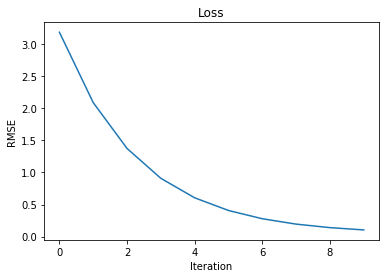

In [24]:
grad_loss_w = tf.gradients(loss, [w])
init = tf.global_variables_initializer()
losses = np.zeros(10)
with tf.Session() as sess:
    # Initialize the variables
    sess.run(init)
    # Gradient descent
    for i in range(0,10):
        # Calculate gradient
        dloss_dw = sess.run(grad_loss_w, {input_x:x,
                                          y_true:y})
        # Apply gradient to weights with learning rate
        sess.run(w.assign(w - 0.1 * dloss_dw[0]))
        # Output the loss
        losses[i] =  sess.run(loss, {input_x:x,
                                     y_true:y})
        print(i+1, 'th Step, current loss: ', losses[i])
    print('Found minimum', sess.run(w))
plt.plot(range(10), losses)
plt.title('Loss')
plt.xlabel('Iteration')
_ = plt.ylabel('RMSE')

Luckily we don't need to program everytime the same algorithm by ourself. TensorFlow provide many of gradient descent algorithms, e.g. 
`tf.train.GradientDescentOptimizer`,  `tf.train.AdagradDAOptimizer` or `tf.train.RMSPropOptimizer` just to mention a few. They  compute the gradient and apply it to the weights automatically.  In the case of the `GradientDescentOptimizer`we only need to specify the learning rate and  tell the optimizer which loss function we want to minimize. We call the method `minimize` which returns our training or optimization operator. In our loop we just need to run the operator.

Found minimum [[1.8796383 2.7672703]]


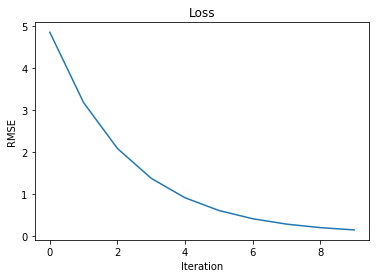

In [25]:
tf.train.RMSPropOptimizer
optimizer = tf.train.GradientDescentOptimizer(0.1)
train = optimizer.minimize(loss)
init = tf.global_variables_initializer()
losses = np.zeros(10)
with tf.Session() as sess:
    # Initialize the variables
    sess.run(init)
    # Gradient descent
    for i in range(0,10):
        _, losses[i] =  sess.run([train, loss], {input_x:x,
                                     y_true:y})
    print('Found minimum', sess.run(w))
plt.plot(range(10), losses)
plt.title('Loss')
plt.xlabel('Iteration')
_ = plt.ylabel('RMSE')

### Stochastic Gradient Descent and Mini-Batch Gradient

One extension to batch gradient descent is the stochastic gradient descent. Instead of calculate the gradient for all observation we just randomly pick one observation (without replacement) an evaluate the gradient at this point. We repeat this until we used all data points, we call this an epoch. We repeat that process for several epochs.

Another variant use more than one random data point per gradient. Its the so called mini-batch gradient. Please feel free to play with the batch_size and the learning rate to see the effect of the optimization. One advantage is that we don't need to keep all data in memory for optimization, especially if we talking about big data. We just need to load small batches at once to calculate the gradient

0 th Epoch Loss:  0.038630348
1 th Epoch Loss:  0.038789663
2 th Epoch Loss:  0.038370226
3 th Epoch Loss:  0.038309097
4 th Epoch Loss:  0.03850872
5 th Epoch Loss:  0.038366485
6 th Epoch Loss:  0.038474593
7 th Epoch Loss:  0.038679037
8 th Epoch Loss:  0.03856797
9 th Epoch Loss:  0.038507216
Found minimum [[1.9929324 2.9882016]]


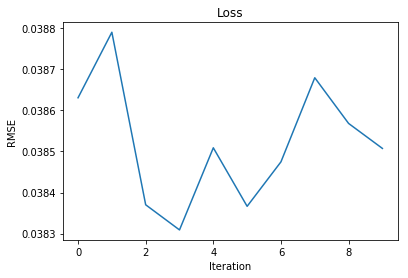

In [28]:
np.random.seed(42)
optimizer = tf.train.GradientDescentOptimizer(0.1)
train = optimizer.minimize(loss)
init = tf.global_variables_initializer()
n_epochs = 10
batch_size = 25
losses = np.zeros(n_epochs)
with tf.Session() as sess:
    # Initialize the variables
    sess.run(init)
    # Gradient descent
    indices = np.arange(x.shape[1])
    for epoch in range(0,n_epochs):
        np.random.shuffle(indices)
        for i in range(int(np.ceil(x.shape[1]/batch_size))):
            idx = indices[i*batch_size:(i+1)*batch_size]
            x_i = x[:,idx]
            x_i = x_i.reshape(2,batch_size)
            y_i = y[idx]
            sess.run(train, {input_x: x_i, 
                             y_true:y_i})
        
        if epoch%1==0: 
            loss_i = sess.run(loss, {input_x: x, 
                             y_true:y})
            print(epoch, 'th Epoch Loss: ', loss_i)
        loss_i = sess.run(loss, {input_x: x, 
                             y_true:y})
        losses[epoch]=loss_i
    print('Found minimum', sess.run(w))
plt.plot(range(n_epochs), losses)
plt.title('Loss')
plt.xlabel('Iteration')
_ = plt.ylabel('RMSE')

## Logistic Regression in TensorFlow

Now we have all tools to build our Logistic Regression model in TensorFlow. 
Its quite similar to our previous toy example. Logisitc regression is also a kind of linear model, it belong to the class of generalized linear models with with the logit as a link function. As we have seen in the previous part we assume in logistic regression that the logits (logarithm of the odds) are linear in the parameters/weights.

Our data set has 30 features, so we adjust the placeholders and the weights accordingly. We have seen that the minimizing the cross entropy is aquivalent to maximizing the likelihood function.. TensorFlow provides us with the loss function `sigmod_cross_entropy`, so we don't need to implement the loss function by ourself (let us use this little shortcut, the cross entropy or negative log likelihood is quite easy to implement). The loss function takes the logits and the true lables (response) as inputs. It computes the entropy elementwise, so we have to take the mean or sum of the output of the loss function.

In [30]:
# Setup the computational graph with loss function
input_x = tf.placeholder(tf.float32, shape=(None, 30))
y_true = tf.placeholder(tf.float32, shape=(None,1))
w = tf.Variable(initial_value=tf.random_normal((30,1), 0, 0.1, seed=42), dtype=tf.float32)
logit = tf.matmul(input_x, w)
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true, logits=logit))

To get the prediction we have to use the sigmoid function on the logits.

In [31]:
y_prob = tf.sigmoid(logit)

For the training we can almost reuse the code of the gradient descent example. We just need to adjust the number of iterations (100, feel free to play with this parameter). and the function call. In each iteration we call our training operator, calculate the current loss and the current probabilities and store the information to visualize the training.

Every ten epoch we print the current loss and AUC score.

In [36]:
optimizer = tf.train.GradientDescentOptimizer(0.5)
train = optimizer.minimize(loss)
init = tf.global_variables_initializer()
n_epochs = 100
losses = np.zeros(n_epochs)
aucs = np.zeros(n_epochs)
with tf.Session() as sess:
    # Initialize the variables
    sess.run(init)
    # Gradient descent
    for i in range(0,n_epochs):
        _, iloss, y_hat =  sess.run([train, loss, y_prob], {input_x: X_train,
                                                           y_true: y_train.reshape(y_train.shape[0],1)})
        losses[i] = iloss
        aucs[i] = roc_auc_score(y_train, y_hat)
        if i%10==0:
            print('%i th Epoch Train AUC: %.4f Loss: %.4f' % (i, aucs[i], losses[i]))
    
    # Calculate test auc
    y_test_hat =  sess.run(y_prob, {input_x: X_test,
                                             y_true: y_test.reshape(y_test.shape[0],1)})
    weights = sess.run(w)

0 th Epoch Train AUC: 0.1518 Loss: 0.7446
10 th Epoch Train AUC: 0.8105 Loss: 0.6960
20 th Epoch Train AUC: 0.8659 Loss: 0.6906
30 th Epoch Train AUC: 0.9640 Loss: 0.6893
40 th Epoch Train AUC: 0.9798 Loss: 0.6884
50 th Epoch Train AUC: 0.9816 Loss: 0.6876
60 th Epoch Train AUC: 0.9818 Loss: 0.6868
70 th Epoch Train AUC: 0.9818 Loss: 0.6861
80 th Epoch Train AUC: 0.9819 Loss: 0.6853
90 th Epoch Train AUC: 0.9820 Loss: 0.6845


We visualize 

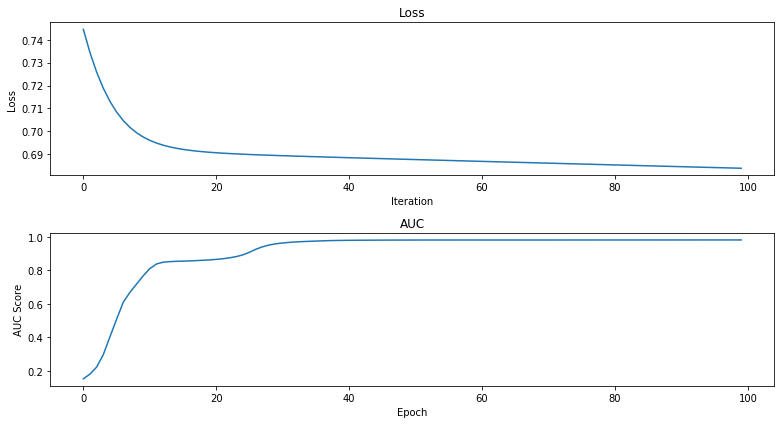

In [35]:
plt.figure(figsize=(11,6))
plt.subplot(2,1,1)
plt.plot(range(n_epochs), losses)
plt.title('Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.subplot(2,1,2)
plt.plot(range(n_epochs), aucs)
plt.title('AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC Score')
plt.tight_layout()

The AUC score of the test date is around 98%.

In [40]:
roc_auc_score(y_test, y_test_hat) * 100

98.14928488618965

Since we have only 30 features we can easily visualize the influence of each feature in our model.

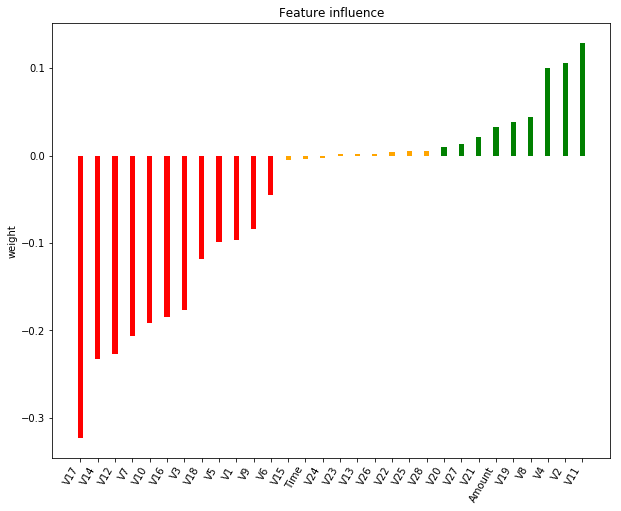

In [42]:
def get_color(c):
    if -0.01 < c and c < 0.0075:
        return 'orange'
    elif c>=0.0075:
        return 'green'
    else:
        return 'red'

plt.figure(figsize=(10,8))
colors = [get_color(c) for c in np.sort(weights[:,0])]
plt.bar(np.arange(30), np.sort(weights[:,0]),  width=0.3, color=colors)
feature_names = X.columns[np.argsort(weights[:,0])]
plt.title('Feature influence')
plt.ylabel('weight')
_ = plt.xticks(np.arange(30), feature_names, rotation=60, ha='right')

So thats it for today. I hoped you enjoyed reading the post. Please download or fork the notebook on GitHub and play with the code and change the parameters.

In the next post we will add a hidden layer to our model and build a neural network. And we will see how to use the High-Level API to build the same model much easier. If you want to learn more about gradient descent and optimization have a look into the following links

* Some lecture note of the Unversity of Toronto: https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf
* And of course Wikipedia.

So long.


